In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# --- 1. 가상 데이터셋 및 에피소드 샘플러 설정 ---

def create_toy_dataset(num_classes=10, samples_per_class=100, num_keypoints=5):
    """
    개념 설명을 위한 가상의 (이미지, 키포인트) 데이터셋을 생성합니다.
    - 이미지는 랜덤 노이즈 텐서로 대체합니다.
    - 키포인트는 0과 1 사이의 랜덤 좌표로 대체합니다.
    """
    dataset = {}
    for i in range(num_classes):
        class_name = f"class_{i}"
        samples = []
        for _ in range(samples_per_class):
            # 가상 이미지 (1채널, 32x32 크기)
            image = torch.rand(1, 32, 32)
            # 가상 키포인트 (5개의 (x, y) 좌표)
            keypoints = torch.rand(num_keypoints, 2)
            samples.append((image, keypoints))
        dataset[class_name] = samples
    return dataset

class EpisodeSampler:
    """
    데이터셋에서 N-way K-shot 에피소드를 무작위로 샘플링하는 클래스
    """
    def __init__(self, dataset, n_way, k_shot, q_queries, num_episodes):
        self.dataset = dataset
        self.n_way = n_way
        self.k_shot = k_shot
        self.q_queries = q_queries
        self.num_episodes = num_episodes
        self.class_names = list(dataset.keys())

    def __iter__(self):
        for _ in range(self.num_episodes):
            # 1. 에피소드에 사용할 N개의 클래스를 무작위로 선택
            selected_classes = np.random.choice(self.class_names, self.n_way, replace=False)
            
            support_images, support_kpts = [], []
            query_images, query_kpts = [], []

            for class_name in selected_classes:
                # 2. 각 클래스에서 Support Set과 Query Set으로 사용할 샘플을 무작위로 선택
                samples = np.random.choice(len(self.dataset[class_name]), self.k_shot + self.q_queries, replace=False)
                
                # Support Set 구성
                for i in samples[:self.k_shot]:
                    img, kpt = self.dataset[class_name][i]
                    support_images.append(img)
                    support_kpts.append(kpt)
                
                # Query Set 구성
                for i in samples[self.k_shot:]:
                    img, kpt = self.dataset[class_name][i]
                    query_images.append(img)
                    query_kpts.append(kpt)
            
            # 텐서로 변환하여 반환
            yield (torch.stack(support_images), torch.stack(support_kpts),
                   torch.stack(query_images), torch.stack(query_kpts))

# --- 2. 메타 학습 모델 정의 ---

class MetaKeypointModel(nn.Module):
    def __init__(self, num_keypoints=5):
        super().__init__()
        # 간단한 CNN 특징 추출기 (Encoder)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(32 * 8 * 8, 128) # 32x32 -> 16x16 -> 8x8
        )
        # 키포인트 예측기 (Decoder)
        # Query 특징(128)과 Task 벡터(128)를 합쳐서 입력받음
        self.decoder = nn.Sequential(
            nn.Linear(128 + 128, 64), nn.ReLU(),
            nn.Linear(64, num_keypoints * 2), # (x, y) 좌표 2개
            nn.Sigmoid() # 좌표를 0~1 사이로 정규화
        )

    def forward(self, support_images, query_images):
        # Support Set 이미지들의 특징을 추출
        # (N*K, 1, 32, 32) -> (N*K, 128)
        support_features = self.encoder(support_images)
        
        # [핵심] Support Set 특징들의 평균을 내어 '과제 벡터(Task Vector)' 생성
        # 이 벡터는 이번 에피소드가 어떤 과제인지를 요약함
        # (N*K, 128) -> (128)
        task_vector = support_features.mean(dim=0)

        # Query Set 이미지들의 특징을 추출
        # (N*Q, 1, 32, 32) -> (N*Q, 128)
        query_features = self.encoder(query_images)
        
        num_queries = query_features.shape[0]
        
        # [핵심] Query 특징에 Task 벡터를 합쳐서 Decoder에 전달
        # (N*Q, 128) -> (N*Q, 128 + 128)
        task_vector_expanded = task_vector.unsqueeze(0).repeat(num_queries, 1)
        combined_features = torch.cat([query_features, task_vector_expanded], dim=1)
        
        # 최종 키포인트 예측
        predicted_kpts = self.decoder(combined_features)
        
        # (N*Q, num_keypoints * 2) -> (N*Q, num_keypoints, 2)
        return predicted_kpts.view(num_queries, -1, 2)

# --- 3. 에피소드 학습 진행 ---

# 하이퍼파라미터
N_WAY = 5
K_SHOT = 1
Q_QUERIES = 5
NUM_EPISODES = 1000
NUM_KEYPOINTS = 5
LEARNING_RATE = 0.001

# 1. 데이터셋과 에피소드 샘플러 준비
toy_dataset = create_toy_dataset(num_classes=20, samples_per_class=100, num_keypoints=NUM_KEYPOINTS)
sampler = EpisodeSampler(toy_dataset, N_WAY, K_SHOT, Q_QUERIES, NUM_EPISODES)

# 2. 모델, 옵티마이저, 손실 함수 정의
model = MetaKeypointModel(num_keypoints=NUM_KEYPOINTS)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss() # 좌표 리그레션이므로 MSE Loss 사용

print("에피소드 학습 시작...")

# 3. 에피소드 루프
for episode_idx, (support_images, support_kpts, query_images, query_kpts) in enumerate(sampler):
    
    optimizer.zero_grad()
    
    # 모델을 통해 Query Set의 키포인트 예측
    predicted_query_kpts = model(support_images, query_images)
    
    # 손실 계산
    loss = criterion(predicted_query_kpts, query_kpts)
    
    # 모델 파라미터 업데이트
    loss.backward()
    optimizer.step()
    
    if (episode_idx + 1) % 100 == 0:
        print(f"[Episode {episode_idx+1}/{NUM_EPISODES}] Loss: {loss.item():.4f}")

print("학습 완료!")

에피소드 학습 시작...
[Episode 100/1000] Loss: 0.0787
[Episode 200/1000] Loss: 0.0924
[Episode 300/1000] Loss: 0.0754
[Episode 400/1000] Loss: 0.0870
[Episode 500/1000] Loss: 0.0807
[Episode 600/1000] Loss: 0.0847
[Episode 700/1000] Loss: 0.0865
[Episode 800/1000] Loss: 0.0866
[Episode 900/1000] Loss: 0.0813
[Episode 1000/1000] Loss: 0.0771
학습 완료!


In [ ]:
class YoloPoseDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.img_dir = os.path.join(data_path, 'images')
        self.label_dir = os.path.join(data_path, 'labels')
        self.img_files = sorted(os.listdir(self.img_dir))
        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def str2float(self, parts):
        return [float(x) for x in parts]

    def str2int(self, parts):
        return [int(x) for x in parts]

    def __getitem__(self, idx):
        img_file = self.img_files[idx]
        label_file = img_file.replace('.jpg', '.txt')

        # 이미지 로드
        img_path = os.path.join(self.img_dir, img_file)
        img = cv2.imread(img_path)
        orig_img = torch.from_numpy(img.copy())
        if self.transform is not None:
            img = self.transform(img)

        # 레이블 로드 (모든 객체)
        label_path = os.path.join(self.label_dir, label_file)
        labels = [] 
        with open(label_path, 'r') as f:
            classes   = []
            boxes     = []
            keypoints = []
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    cls = self.str2int(parts[0])
                    box = self.str2float(parts[1:5])
                    keypoint = self.str2float(parts[5:])
                    keypoint.insert(2, 1.)
                    keypoint.insert(5, 1.)
                    keypoint.insert(8, 1.)
                    keypoint.append(1.)
        #             labels.append(cls + box + keypoint)
        # labels = torch.FloatTensor(labels)
                    boxes.append(box)
                    classes.append(cls)
                    keypoints.append(keypoint)
        classes   = torch.LongTensor(classes)
        boxes     = torch.FloatTensor(boxes)
        keypoints = torch.FloatTensor(keypoints).reshape(-1, 4, 3)
        labels = {
            "boxes": boxes,         # (N_obj, 4)
            "labels": classes,       # (N_obj,)
            "kpts": keypoints,           # (N_obj, num_kpts, 3)
        }


        return img, labels, orig_img
    

In [1]:
import os 
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

class CustomDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.img_dir = os.path.join(data_path, 'images')
        self.label_dir = os.path.join(data_path, 'labels')
        self.img_files = sorted(os.listdir(self.img_dir))
        self.transform = transform    
        self.class_dict = self.divClass()  # 클래스별로 이미지와 레이블 파일을 분류

    def __len__(self):
        return len(self.img_files)

    def divClass(self):
        class_dict = {}
        for img_file in self.img_files:
            label_file = img_file.replace('.jpg', '.txt')
            with open(os.path.join(self.label_dir, label_file), 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        cls = int(parts[0])
                        if cls not in class_dict:
                            class_dict[cls] = []
                        class_dict[cls].append((img_file, label_file))
                        break
        return class_dict

    def __getitem__(self, class_name, idx):
        img_file, label_file = self.class_dict[class_name][idx]

        # 이미지 로드
        img_path = os.path.join(self.img_dir, img_file)
        img = cv2.imread(img_path)
        if self.transform is not None:
            img = self.transform(img)

        # 레이블 로드
        label_path = os.path.join(self.label_dir, label_file)
        labels = []
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    class_name = int(parts[0])
                    keypoints = [float(x) for x in parts[5:]]

        labels = torch.FloatTensor(keypoints).reshape(-1, 2)
        
        return img, labels

# --- 이전 예제와 동일한 가상 데이터셋 및 샘플러 사용 ---
# (이전 코드의 create_toy_dataset, EpisodeSampler 클래스를 그대로 사용한다고 가정합니다)
def create_toy_dataset(num_classes=10, samples_per_class=100, num_keypoints=5):
    dataset = {}
    for i in range(num_classes):
        class_name = f"class_{i}"
        samples = []
        for _ in range(samples_per_class):
            # FPN은 3채널 이미지를 사용하므로 채널 변경
            image = torch.rand(3, 128, 128) # 이미지 크기 증가
            # 이 예제에서는 단일 키포인트를 예측한다고 가정
            keypoints = torch.rand(num_keypoints, 2) * 128 # 0~128 사이 좌표
            samples.append((image, keypoints))
        dataset[class_name] = samples
    return dataset

class EpisodeSampler:
    # 이전 예제와 동일
    def __init__(self, dataset, n_way, k_shot, q_queries, num_episodes):
        self.dataset = dataset
        self.n_way = n_way
        self.k_shot = k_shot
        self.q_queries = q_queries
        self.num_episodes = num_episodes
        self.class_names = list(dataset.class_dict.keys())
        
    def __iter__(self):
        for _ in range(self.num_episodes):
            selected_classes = np.random.choice(self.class_names, self.n_way, replace=False)
            support_images, support_kpts, query_images, query_kpts = [], [], [], []
            for class_name in selected_classes:
                samples = np.random.choice(len(self.dataset.class_dict[class_name]), self.k_shot + self.q_queries, replace=False)
                for i in samples[:self.k_shot]:
                    img, kpt = self.dataset.__getitem__(class_name, i)
                    support_images.append(img); support_kpts.append(kpt)
                for i in samples[self.k_shot:]:
                    img, kpt = self.dataset.__getitem__(class_name, i)
                    query_images.append(img); query_kpts.append(kpt)
            yield (torch.stack(support_images), torch.stack(support_kpts), torch.stack(query_images), torch.stack(query_kpts))


# --- FPN 기반 메타 학습 모델 정의 ---

class FPN_FSKD_Model(nn.Module):
    def __init__(self, backbone_name='resnet34', pretrained_backbone=True, num_keypoints=5):
        super().__init__()
        # 1. ResNet + FPN 백본을 torchvision에서 불러옵니다.
        # FPN은 여러 스케일의 특징 맵을 OrderedDict 형태로 반환합니다.
        self.backbone = resnet_fpn_backbone(backbone_name, pretrained=pretrained_backbone)
        
        fpn_out_channels = self.backbone.out_channels # 보통 256
        
        # 2. 각 FPN 레벨별로 예측을 수행할 '예측 헤드(Prediction Head)'를 정의합니다.
        # 각 헤드는 독립적인 가중치를 가집니다.
        self.prediction_heads = nn.ModuleList()
        # FPN은 보통 5개의 레벨(P2, P3, P4, P5, P6)을 출력합니다.
        num_fpn_levels = 5
        for _ in range(num_fpn_levels):
            # 각 헤드는 (Query 특징 + Task 벡터)를 입력받아 히트맵을 출력합니다.
            # 입력 채널: 256(Query) + 256(Task) = 512
            head = nn.Sequential(
                nn.Conv2d(fpn_out_channels * 2, fpn_out_channels, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(fpn_out_channels, num_keypoints, kernel_size=1) # 최종 히트맵 출력
            )
            self.prediction_heads.append(head)

    def forward(self, support_images, query_images):
        num_support = support_images.shape[0]
        num_query = query_images.shape[0]
        
        # Support와 Query 이미지를 합쳐서 한 번에 특징 추출
        combined_images = torch.cat([support_images, query_images], dim=0)
        
        # 1. FPN 백본을 통해 멀티스케일 특징 추출
        # fpn_features는 {'0': P2_feats, '1': P3_feats, ...} 형태의 딕셔너리
        fpn_features = self.backbone(combined_images)
        fpn_levels = list(fpn_features.values())

        final_heatmaps = []
        
        # 2. 각 FPN 레벨(P2, P3, ...)을 순회하며 메타 러닝 수행
        for i, level_features in enumerate(fpn_levels):
            # (N*K+N*Q, C, H, W) -> Support와 Query 특징으로 분리
            support_feats_level = level_features[:num_support]
            query_feats_level = level_features[num_support:]
            
            # [핵심] 해당 레벨의 '과제 벡터(Task Vector)' 생성
            # (N*K, C, H, W) -> (1, C, H, W)
            task_vector_level = support_feats_level.mean(dim=0, keepdim=True)
            
            # Query 특징에 Task 벡터를 결합
            # task_vector를 query 개수만큼 복제하여 채널 방향으로 concat
            task_vector_expanded = task_vector_level.expand(num_query, -1, -1, -1)
            combined_query_feats = torch.cat([query_feats_level, task_vector_expanded], dim=1)
            
            # 해당 레벨의 예측 헤드를 사용하여 히트맵 예측
            heatmap_level = self.prediction_heads[i](combined_query_feats)
            final_heatmaps.append(heatmap_level)
            
        # 3. 모든 레벨의 히트맵을 최종적으로 통합
        # 가장 큰 해상도(첫 번째 레벨, P2)에 맞춰 업샘플링 후 합산
        target_size = final_heatmaps[0].shape[2:]
        aggregated_heatmap = torch.zeros_like(final_heatmaps[0])
        
        for heatmap in final_heatmaps:
            upsampled_heatmap = F.interpolate(heatmap, size=target_size, mode='bilinear', align_corners=False)
            aggregated_heatmap += upsampled_heatmap
            
        return aggregated_heatmap

# --- 히트맵 생성 및 학습 진행 ---

def create_target_heatmap(keypoints, output_size, sigma=1.0):
    """주어진 키포인트 좌표를 기반으로 가우시안 히트맵(정답)을 생성합니다."""
    batch_size, num_kpts, _ = keypoints.shape
    H, W = output_size
    target_heatmaps = torch.zeros(batch_size, num_kpts, H, W)

    for b in range(batch_size):
        for k in range(num_kpts):
            mu_x, mu_y = keypoints[b, k, 0]*64, keypoints[b, k, 1]*64

            x = torch.arange(0, W, 1, dtype=torch.float32)
            y = torch.arange(0, H, 1, dtype=torch.float32).unsqueeze(-1)

            # 가우시안 분포 계산
            gaussian = torch.exp(-((x - mu_x)**2 + (y - mu_y)**2) / (2 * sigma**2))
            target_heatmaps[b, k] = gaussian
            
    return target_heatmaps

# 하이퍼파라미터
N_WAY, K_SHOT, Q_QUERIES = 4, 1, 5
NUM_EPISODES, LEARNING_RATE = 1000, 0.001
NUM_KEYPOINTS = 1
IMAGE_SIZE, HEATMAP_SIZE = (256, 256), (64, 64) # 원본 이미지, 최종 히트맵 크기

# 준비

img_size = (256, 256)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(img_size),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# DataLoader
base = '/home/otter/dataset/pallet/dataset/train'

toy_dataset = CustomDataset(base, transform=transform)
sampler = EpisodeSampler(toy_dataset, N_WAY, K_SHOT, Q_QUERIES, NUM_EPISODES)
model = FPN_FSKD_Model(num_keypoints=NUM_KEYPOINTS).to('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
criterion = nn.MSELoss() # 예측 히트맵과 정답 히트맵의 MSE Loss

print("FPN 기반 에피소드 학습 시작...")
for episode_idx, (_, _, query_images, query_kpts) in enumerate(sampler):
    # 이 예제에서는 support set을 모델 내부에서만 사용하므로 _ 로 받음
    # 실제로는 support_images도 모델에 전달해야 함 (코드 수정)
    support_images, _, _, _ = next(iter(sampler)) # 간단하게 다른 에피소드에서 support set 가져옴
    
    optimizer.zero_grad()
    
    # 모델 예측
    predicted_heatmaps = model(support_images.cuda(), query_images.cuda())
    predicted_heatmaps = predicted_heatmaps.cpu()  # GPU에서 CPU로 이동 (필요시)
    # 정답 히트맵 생성 (좌표를 히트맵으로 변환)
    # 모델 출력 크기에 맞게 좌표 스케일링 필요
    kpts_for_heatmap = query_kpts * (HEATMAP_SIZE[0] / IMAGE_SIZE[0])
    target_heatmaps = create_target_heatmap(kpts_for_heatmap, HEATMAP_SIZE)

    # 손실 계산
    loss = criterion(predicted_heatmaps, target_heatmaps)
    
    loss.backward()
    optimizer.step()
    
    if (episode_idx + 1) % 100 == 0:
        print(f"[Episode {episode_idx+1}/{NUM_EPISODES}] Loss: {loss.item():.6f}")

print("학습 완료!")

/home/otter/miniconda3/envs/fskd/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/otter/miniconda3/envs/fskd/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/otter/miniconda3/envs/fskd/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FPN 기반 에피소드 학습 시작...


/home/otter/miniconda3/envs/fskd/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([20, 4, 64, 64])) that is different to the input size (torch.Size([20, 1, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Episode 100/1000] Loss: 0.001363
[Episode 200/1000] Loss: 0.000954
[Episode 300/1000] Loss: 0.000820
[Episode 400/1000] Loss: 0.000783
[Episode 500/1000] Loss: 0.000768
[Episode 600/1000] Loss: 0.000734
[Episode 700/1000] Loss: 0.000720
[Episode 800/1000] Loss: 0.000695
[Episode 900/1000] Loss: 0.000687
[Episode 1000/1000] Loss: 0.000703
학습 완료!


In [2]:
target_heatmaps

tensor([[[[2.8099e-27, 1.9629e-24, 5.0446e-22,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.5421e-24, 5.9674e-21, 1.5336e-18,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [9.5533e-21, 6.6738e-18, 1.7151e-15,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[3.9421e-29, 2.7608e-26, 7.1128e-24,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.9463e-25, 1.3631e-22, 3.5118e-20,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.5351e-22, 2.4757e-19, 6.3785e-17,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000

In [ ]:
p3 = fpn_features['2']
p4 = fpn_features['3']
p5 = fpn_features['pool']

In [27]:
512/16


32.0

FPN Output Channels: 256
Level 0: torch.Size([1, 256, 128, 128])
Level 1: torch.Size([1, 256, 64, 64])
Level 2: torch.Size([1, 256, 32, 32])
Level 3: torch.Size([1, 256, 16, 16])
Level pool: torch.Size([1, 256, 8, 8])


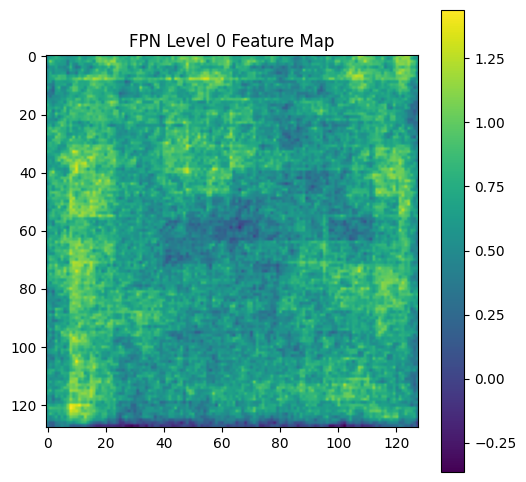

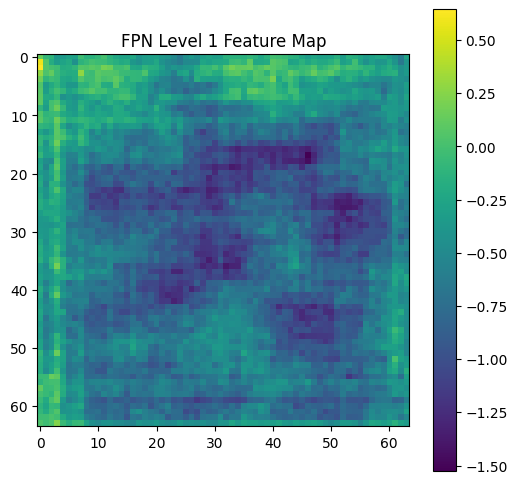

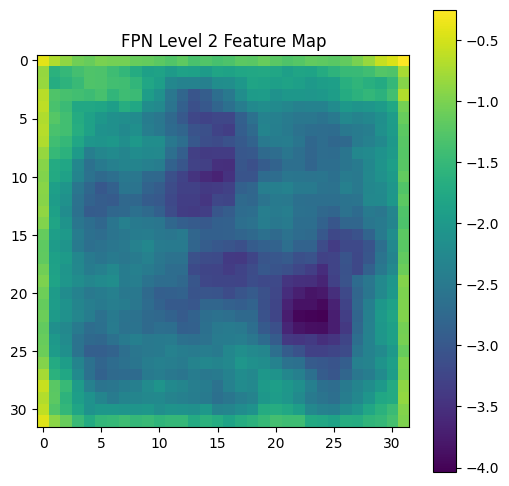

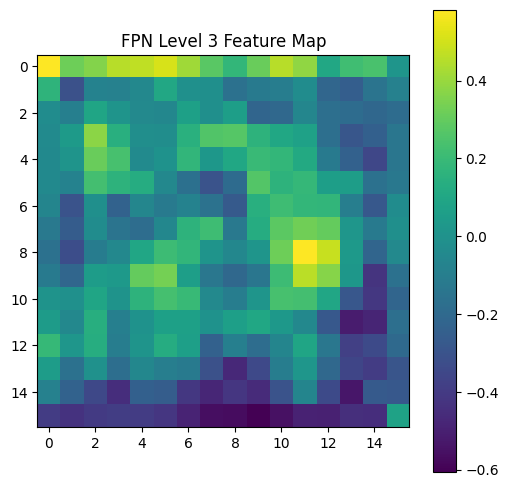

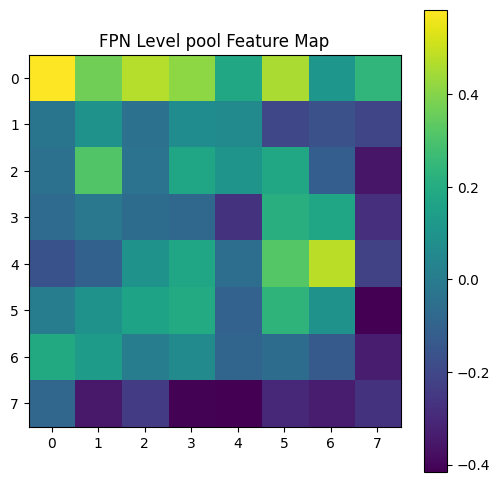

In [24]:
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import torch 
model = resnet_fpn_backbone('resnet50', pretrained=True)
model.eval()  # 평가 모드로 전환
# 모델의 출력 채널 수 확인
print(f"FPN Output Channels: {model.out_channels}")
# FPN의 출력 채널 수는 보통 256입니다.
image = torch.rand(1, 3, 512, 512)  # 임의의 입력 이미지
fpn_features = model(image)
# FPN의 출력 특징 맵 확인
for level, features in fpn_features.items():
    print(f"Level {level}: {features.shape}")  # 각 레벨의 특징 맵 크기 출력
# FPN의 출력 특징 맵은 {'0': P2_feats, '1': P3_feats, ...} 형태입니다.
# 각 레벨의 특징 맵 크기는 (batch_size, channels, height, width) 형태입니다.
# 예시로 P2 레벨의 특징 맵을 시각화할 수 있습니다.
import matplotlib.pyplot as plt
def visualize_fpn_features(fpn_features):
    for level, features in fpn_features.items():
        # 첫 번째 배치의 첫 번째 채널을 시각화
        feature_map = features[0, 0].detach().cpu().numpy()
        plt.figure(figsize=(6, 6))
        plt.imshow(feature_map, cmap='viridis')
        plt.title(f'FPN Level {level} Feature Map')
        plt.colorbar()
        plt.show()
visualize_fpn_features(fpn_features)
# FPN 특징 맵 시각화 함수 호출